In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
import sys
sys.path.insert(1, 'scripts/')
from gen_matrix import matrix_gen, get_ICA
from get_sample import get_sample, create_strings_for_dataset
from fft import fft_for_sample
from tqdm import tqdm 
%matplotlib inline

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [6]:
import operator

In [7]:
def generate_simple_dataset(linspace, chanals, pandas=False):
    p1,p2,p3 = linspace
    v = np.linspace(p1, p2, p3)
    
    dataset = v
    for i in range(chanals-1):
        dataset = np.vstack((dataset, v))
        
    if pandas:
        return pd.DataFrame(dataset)
    
    return dataset

def func_for_1class(t, noise=0.5):
    return 2*np.cos(5*2*pi*t) + 5*np.cos(15*2*pi*t) + 3*np.cos(20*2*pi*t) + noise

def func_for_2class(t, noise=0.5):
    return 3*np.cos(5*2*pi*t) + 2*np.cos(15*2*pi*t) + 3*np.cos(20*2*pi*t) + noise

def func_for_3class(t, noise=0.5):
    return 4*np.cos(5*2*pi*t) + 10*np.cos(15*2*pi*t) + 3*np.cos(20*2*pi*t) + noise

def func_general(t, noise=0.5):
    return 9*np.cos(5*2*pi*t) + 10*np.cos(15*2*pi*t) + 3*np.cos(20*2*pi*t) + noise

def get_cosinus_matrix(chanals, linspace):
    data_simple = generate_simple_dataset(linspace, chanals)
    vec = data_simple[0]
    
    size = (chanals, linspace[2])
    class_ = size[1]//3
    class1 = [0,class_]
    class2 = [class_,class_*2]
    class3 = [class_*2, data_simple.shape[1]]
    
    
    vec[class1[0]:class1[1]] = func_for_1class(vec[class1[0]:class1[1]])
    vec[class2[0]:class2[1]] = func_for_2class(vec[class2[0]:class2[1]])
    vec[class3[0]:class3[1]] = func_for_3class(vec[class3[0]:class3[1]])
    

    data_simple = func_general(data_simple)
    data_simple[0] = data_simple[1]
    data_simple[65] = vec

    
    return data_simple

In [8]:
CHANALS = 128
LINSPACE = 0, 200, 20000
FIRST_N_FFT = 20
N_COMPONENTS_PCA = 60

matrix = get_cosinus_matrix(chanals=CHANALS, linspace=LINSPACE)
size = matrix.shape
class_ = class_ = size[1]//3

In [11]:
matrix[65]

array([10.5       ,  6.26771065, -1.85480867, ..., -1.78234478,
       11.10854961, 17.5       ])

In [12]:
matrix[64]

array([22.5       , 15.86380792,  2.26264786, ...,  2.26264786,
       15.86380792, 22.5       ])

In [13]:
matrix_class1 = matrix[:,0:class_]
matrix_calss2 = matrix[:, class_:class_*2]
matrix_calss3 = matrix[:, class_*2:matrix.shape[1]]
#Получаем семплы для каждого класса
sample_calss1 = get_sample(matrix_class1, sample_size=300, step=100)
sample_calss2 = get_sample(matrix_calss2, sample_size=300, step=100)
sample_calss3 = get_sample(matrix_calss3, sample_size=300, step=100)






#Преобразование Фурье

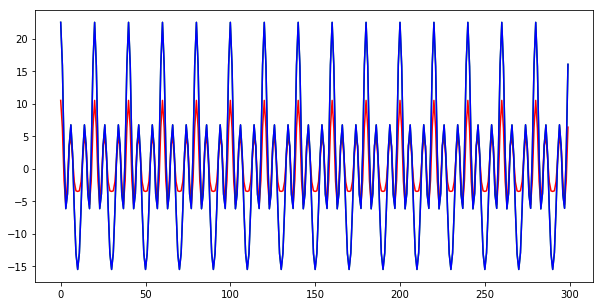

In [31]:
plt.figure(figsize=(10,5))
plt.plot(sample_calss1[0][65], c='r')
plt.plot(sample_calss1[0][64], c='g')
plt.plot(sample_calss1[0][63], c='b')
plt.show()

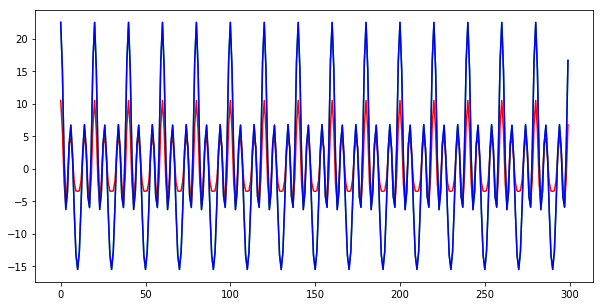

In [33]:
plt.figure(figsize=(10,5))
plt.plot(sample_calss1[10][65], c='r')
plt.plot(sample_calss1[10][64], c='g')
plt.plot(sample_calss1[10][63], c='b')
plt.show()

In [34]:
i_ = 0
for i in range(len(sample_calss1)):
    for j in range(sample_calss1[0].shape[0]):
        #print(sample_calss1[i][j].shape[0])
        if sample_calss1[i][j].shape[0] != 300:
            if i_ == 0:
                i_ = i




In [36]:
sample_calss1 = sample_calss1[:64]
sample_calss2 = sample_calss2[:64]
sample_calss3 = sample_calss3[:64]

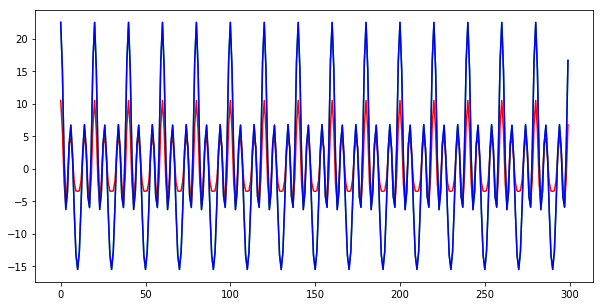

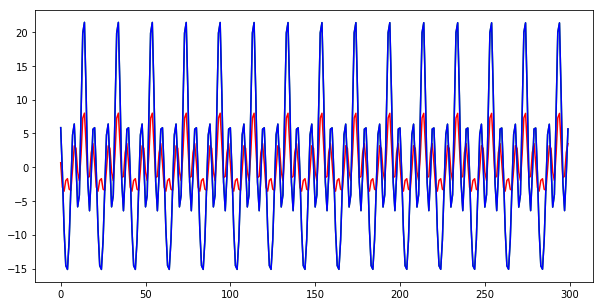

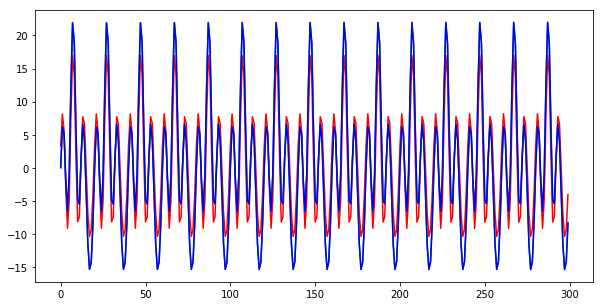

In [45]:
plt.figure(figsize=(10,5))
plt.plot(sample_calss1[10][65], c='r')
plt.plot(sample_calss1[10][64], c='g')
plt.plot(sample_calss1[10][63], c='b')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sample_calss2[10][65], c='r')
plt.plot(sample_calss2[10][64], c='g')
plt.plot(sample_calss2[10][63], c='b')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sample_calss3[10][65], c='r')
plt.plot(sample_calss3[10][64], c='g')
plt.plot(sample_calss3[10][63], c='b')
plt.show()

In [42]:
samples_fft = list(fft_for_sample(sample_calss1 + sample_calss2 + sample_calss3, freq=100))


In [43]:
len_class = len(sample_calss1)
sample_calss1_fft = samples_fft[:len_class]
sample_calss2_fft = samples_fft[len_class:len_class*2]
sample_calss3_fft = samples_fft[len_class*2:]

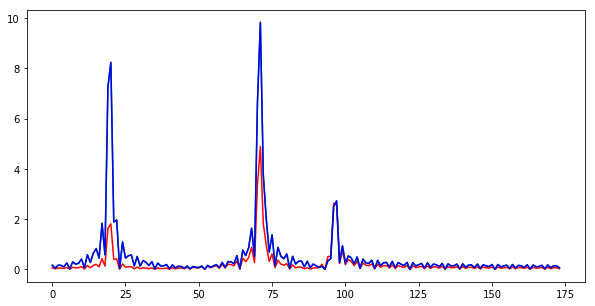

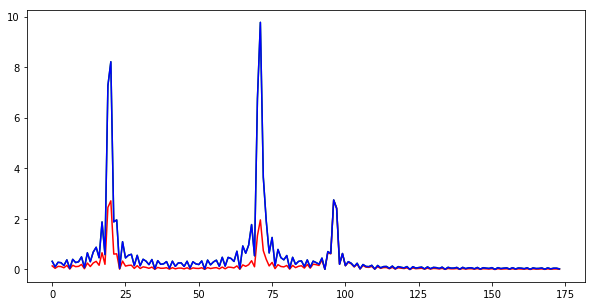

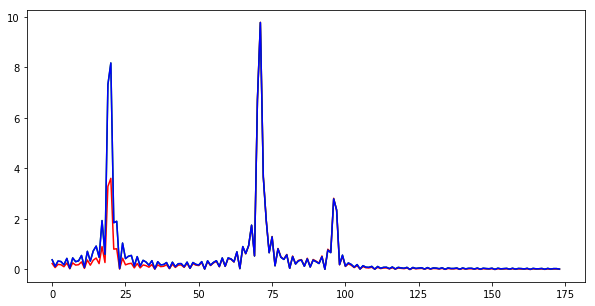

In [44]:
plt.figure(figsize=(10,5))
plt.plot(sample_calss1_fft[10][65], c='r')
plt.plot(sample_calss1_fft[10][64], c='g')
plt.plot(sample_calss1_fft[10][63], c='b')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sample_calss2_fft[10][65], c='r')
plt.plot(sample_calss2_fft[10][64], c='g')
plt.plot(sample_calss2_fft[10][63], c='b')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sample_calss3_fft[10][65], c='r')
plt.plot(sample_calss3_fft[10][64], c='g')
plt.plot(sample_calss3_fft[10][63], c='b')
plt.show()

In [128]:
for i in range(len(sample_calss1_fft)):
    for j in range(sample_calss1_fft[0].shape[0]):
        sh = sample_calss1_fft[i][j].shape[0]
        if sh != 174:
            print(sh)

In [55]:
(sample_calss1_fft[0]).shape

(128, 174)

In [64]:
sample_calss1_fft[0][65]

array([7.19408252e-02, 2.29264624e-02, 6.44815306e-02, 6.06381032e-02,
       3.66755600e-02, 8.76349661e-02, 8.57146899e-03, 9.42622705e-02,
       6.38008146e-02, 7.27528052e-02, 1.17856710e-01, 1.82833026e-02,
       1.56582211e-01, 7.19320745e-02, 1.62880321e-01, 2.05386931e-01,
       1.08564239e-01, 4.32990836e-01, 1.33283813e-01, 1.63166921e+00,
       1.81415406e+00, 4.06967352e-01, 4.16411005e-01, 7.28539910e-03,
       2.22296109e-01, 9.08562365e-02, 1.07492994e-01, 1.13337369e-01,
       2.70063871e-02, 1.00233244e-01, 2.66804369e-02, 6.95402903e-02,
       5.70815531e-02, 3.22012408e-02, 6.78417757e-02, 5.17025428e-03,
       6.21234771e-02, 3.78689304e-02, 4.21666020e-02, 6.16348293e-02,
       1.05194952e-02, 7.11722842e-02, 2.80735123e-02, 6.17206402e-02,
       6.51685789e-02, 3.15975444e-02, 9.00334094e-02, 1.55099409e-02,
       9.20707202e-02, 6.95052987e-02, 6.45079295e-02, 1.15402169e-01,
       7.69809873e-03, 1.36237420e-01, 6.91874664e-02, 1.17555143e-01,
      

In [56]:
#Создание строк для датасета, из матрицы 128*174 -> в вектор 22272
sample_calss1_fft_str = create_strings_for_dataset(sample_calss1_fft)
sample_calss2_fft_str = create_strings_for_dataset(sample_calss2_fft)
sample_calss3_fft_str = create_strings_for_dataset(sample_calss3_fft)

In [88]:
def values_65(samples_fft):
    strings = []
    for i in range(len(samples_fft)):
        new_string = []
        for n in range(samples_fft[i].shape[1]):
            new_string.append(samples_fft[i][65,n])
        strings.append(new_string)

    return strings


In [108]:
def index_65(sample_calss_fft_str, sample_calss_fft_str_65):
    index = []
    for i in range(len(sample_calss_fft_str)):
        index_sample = []
        for n in range(len(sample_calss_fft_str_65[i])):
            idx = sample_calss_fft_str[i].index(sample_calss_fft_str[i][n])
            index_sample.append(idx)
            
            
        index.append(index_sample)
            
    return index

In [119]:
def index_65(sample_calss_fft_str, sample_calss_fft_str_65):
    indexes = []
    for i in range(len(sample_calss1_fft_str)):
        index = []
        for j in range(len(sample_calss_fft_str_65[i])):
            index.append(sample_calss_fft_str[i].index(sample_calss_fft_str_65[i][j]))
        indexes.append(index)
    return indexes

In [120]:
sample_calss_1_fft_str_65 = values_65(sample_calss1_fft)
sample_calss_2_fft_str_65 = values_65(sample_calss2_fft)
sample_calss_3_fft_str_65 = values_65(sample_calss3_fft)


sample_calss_1_fft_str_65_index = index_65(sample_calss1_fft_str, sample_calss_1_fft_str_65)
sample_calss_2_fft_str_65_index = index_65(sample_calss2_fft_str, sample_calss_2_fft_str_65)
sample_calss_3_fft_str_65_index = index_65(sample_calss3_fft_str, sample_calss_3_fft_str_65)
    


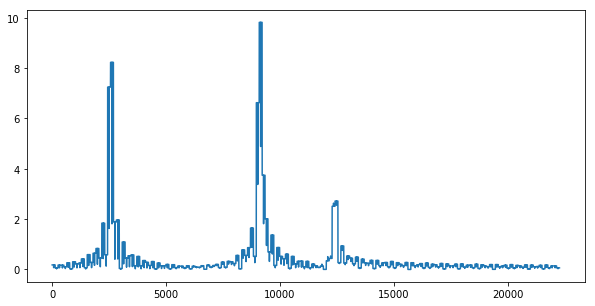

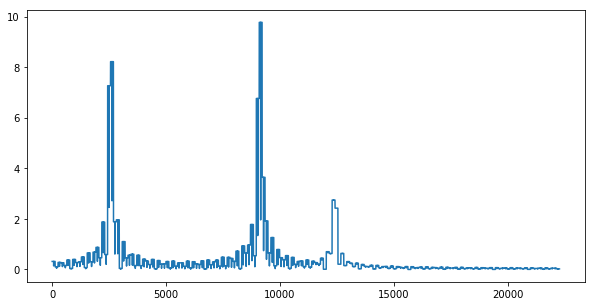

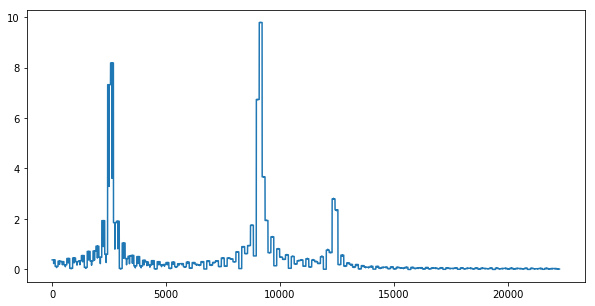

In [139]:
plt.figure(figsize=(10,5))
plt.plot(sample_calss1_fft_str[0])
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sample_calss2_fft_str[0])
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sample_calss3_fft_str[0])
plt.show()

In [140]:
len_class

64

In [144]:



#Создание таблицы объекты-признаки

#Класс 1
data_class_1 = pd.DataFrame(data=np.zeros((len_class, size[0] * 174)))
data_class_1['label'] = 1

for i in tqdm(range(len(sample_calss1_fft_str))):
    data_class_1.iloc[i, :-1] = sample_calss1_fft_str[i]
    
    
#Класс 2
data_class_2 = pd.DataFrame(data=np.zeros((len_class, size[0] * 174)))
data_class_2['label'] = 2

for i in tqdm(range(len(sample_calss2_fft_str))):
    data_class_2.iloc[i, :-1] = sample_calss2_fft_str[i]
    
    
#Класс 3
data_class_3 = pd.DataFrame(data=np.zeros((len_class, size[0] * 174)))
data_class_3['label'] = 3

for i in tqdm(range(len(sample_calss3_fft_str))):
    data_class_3.iloc[i, :-1] = sample_calss3_fft_str[i]
    
    
data = pd.concat([data_class_1, data_class_2, data_class_3], axis=0)
print(data.shape)

100%|██████████| 64/64 [03:47<00:00,  3.55s/it]

(192, 22273)


In [155]:
data.iloc[:, 65]

0     0.071941
1     0.071370
2     0.070798
3     0.070226
4     0.069653
5     0.069080
6     0.068506
7     0.067933
8     0.067358
9     0.066784
10    0.066209
11    0.065634
12    0.065059
13    0.064484
14    0.063909
15    0.063334
16    0.062759
17    0.062184
18    0.061610
19    0.061035
20    0.060461
21    0.059888
22    0.059315
23    0.058742
24    0.058170
25    0.057599
26    0.057028
27    0.056458
28    0.055889
29    0.055322
        ...   
34    0.234292
35    0.234286
36    0.234278
37    0.234268
38    0.234255
39    0.234239
40    0.234221
41    0.234200
42    0.234176
43    0.234150
44    0.234121
45    0.234089
46    0.234055
47    0.234018
48    0.233979
49    0.233937
50    0.233893
51    0.233845
52    0.233796
53    0.233743
54    0.233688
55    0.233631
56    0.233570
57    0.233507
58    0.233442
59    0.233374
60    0.233303
61    0.233230
62    0.233154
63    0.233076
Name: 65, Length: 192, dtype: float64

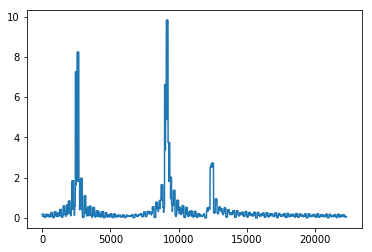

In [153]:
plt.plot(data_class_1.iloc[1, :-1])

In [156]:
## Понизим размерность до 60 компонент
PCA = PCA(n_components=N_COMPONENTS_PCA)

#Стандартизируем матрицу
Scaler = StandardScaler()
data_standart = Scaler.fit_transform((data).iloc[:, :-1])
# Понижаем размерность
data_pca = PCA.fit_transform(data_standart)
data_pca = pd.DataFrame(data_pca)

# data_pca['label'] = data['label'].values
labels = data['label'].values

#Посмотрим важные признаки с помощью RF
rf = RandomForestClassifier()
rf.fit(data_pca, labels)

/Users/alexandr/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

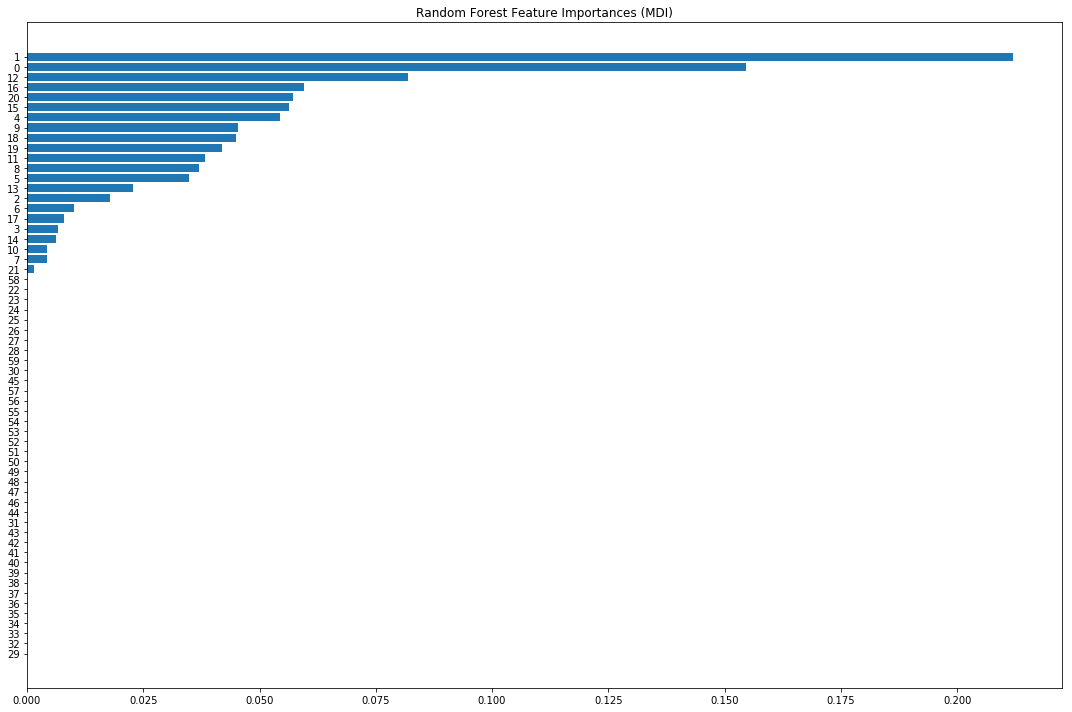

In [157]:
tree_feature_importances = (rf.feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(data_pca.columns))
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(data_pca.columns[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.savefig('RF PCA Feature Importances')
plt.show()

In [158]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = data_pca.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [159]:
def scoring_fi(feature_importances):
    above_zero = feature_importances['importance'][:np.sum(feature_importances['importance'] > 0)]
    mean_value = above_zero.mean()
    features_good = above_zero[above_zero > mean_value].index.tolist()
    features_normal = above_zero[above_zero <= mean_value].index.tolist()
    features_bad = [i for i in feature_importances.index.tolist() if i not in features_good and
                    i not in features_normal]
    
    features_good = str(features_good).strip('[]').split(' ')
    features_normal = str(features_normal).strip('[]').split(' ')
    features_bad = str(features_bad).strip('[]').split(' ')
    
    return features_good, features_normal, features_bad

In [160]:
train_features = data_standart
from sklearn.decomposition import PCA
model = PCA(n_components=N_COMPONENTS_PCA).fit(train_features)
X_pc = model.transform(train_features)

features_good, features_normal, features_bad = scoring_fi(feature_importances)

In [170]:
model.components_[:, 65]

array([-6.41889878e-03, -8.58332081e-03,  7.98562858e-03,  4.26868000e-03,
       -3.73300080e-02, -6.01081717e-03, -2.59276220e-02, -2.09519395e-02,
        1.35607553e-02,  2.37938121e-02, -3.58390630e-02,  1.15468329e-02,
       -3.14215609e-02,  1.09970096e-02, -2.79318044e-02,  3.63967225e-02,
       -9.86251154e-03, -3.12904693e-02, -5.91779894e-03, -4.32304431e-02,
       -3.88619107e-03, -1.27129245e-02, -1.40200348e-01, -5.32556325e-03,
       -1.12914424e-02, -1.24897404e-02, -1.87528238e-02,  2.09764673e-02,
       -1.77273179e-02,  8.82291038e-05,  1.44538973e-02, -3.04925217e-02,
        3.15850221e-02, -1.93774868e-02, -3.45480863e-02,  1.72011731e-02,
       -1.99074672e-03, -5.11640396e-02,  4.49416392e-02,  2.05983855e-02,
       -5.15082386e-02, -7.61814331e-03,  5.62461353e-03,  1.89582192e-02,
        2.82706023e-02, -1.45969660e-02,  1.88473155e-02, -1.85641382e-04,
       -1.64777305e-02, -2.85123162e-02,  1.49115554e-02,  1.18139306e-03,
       -4.58343765e-03,  

In [171]:
# def features_imp_pca(train_features, model_pca, X_pca, features_good, features_bad, features_normal):
    
#     global size, N_COMPONENTS_PCA, FIRST_N_FFT
    
#     reward_best = 50
#     reward_max = 10
#     reward_med = 5
#     reward_min = 1
    
#     fe_imp = {}
#     for feature in range(0, size[1]):
#         fe_imp['feature' + '_' + str(feature)] = 0
        
#     component_max_list = [abs(pd.DataFrame(model_pca.components_).loc[i, :]).max() for i in range(N_COMPONENTS_PCA)]
#     component_mean_list = [abs(pd.DataFrame(model_pca.components_).loc[i, :]).mean() for i in range(N_COMPONENTS_PCA)]
        
#     for feature in tqdm(range(0, size[0]*FIRST_N_FFT)):
#         reward = 0
#         for component in range(0, N_COMPONENTS_PCA):
#             feature_value =abs( model_pca.components_[component, feature])
#             component_max = component_max_list[component]
#             component_mean = component_mean_list[component]
            
#             comparison_max = component_max - component_max / 10
#             comparison_med = component_max - component_max / 20
#             comparison_min = component_mean
            
            
            
#             if feature_value >= comparison_min:
#                 if str(component) in features_bad:
#                     reward -= reward_min
#                 elif str(feature) in features_good or str(feature) in features_normal:
#                     reward += reward_min
            
#             if feature_value >= comparison_med:
#                 if str(component) in features_bad:
#                     reward -= reward_med
#                 elif str(component) in features_normal:
#                     reward += reward_med
#                 elif str(component) in features_good:
#                     reward += reward_max
            
#             if feature_value >= comparison_max:
#                 if str(component) in features_bad:
#                     reward -= reward_max
#                 elif str(component) in features_normal:
#                     reward += reward_max
#                 elif str(component) in features_good:
#                     reward += reward_best #best
                    
#             if feature_value <= comparison_min:
#                 if str(component) in features_bad:
#                     reward += reward_min
#                 elif str(component) in features_good or str(feature) in features_normal:
#                     reward -= reward_min
                    
                    
#         fe_imp['feature' + '_' + str(feature)] = reward
            
#     return fe_imp
            
            
    
    
    

In [172]:
def features_imp_pca(train_features, model_pca, X_pca, features_good, features_bad, features_normal):
    
    global size, N_COMPONENTS_PCA, FIRST_N_FFT
    
    reward_best = 50
    reward_max = 10
    reward_med = 5
    reward_min = 1
    
    fe_imp = {}
    for feature in range(0, size[1]):
        fe_imp['feature' + '_' + str(feature)] = 0
        
    component_max_list = [(pd.DataFrame(abs(model_pca.components_)).loc[i, :]).max() for i in range(N_COMPONENTS_PCA)]
    component_mean_list = [(pd.DataFrame(abs(model_pca.components_)).loc[i, :]).mean() for i in range(N_COMPONENTS_PCA)]
        
    for feature in tqdm(range(0, size[0]*FIRST_N_FFT)):
        reward = 0
        for component in range(0, N_COMPONENTS_PCA):
            feature_value = abs(model_pca.components_)[component, feature]
            component_max = component_max_list[component]
            component_mean = component_mean_list[component]
            
            comparison_max = component_max - component_max / 10
            comparison_med = component_max - component_max / 20
            comparison_min = component_mean
            
            
            
            if feature_value >= comparison_min:
                if str(component) in features_bad:
                    reward -= reward_min
                elif str(feature) in features_good or str(feature) in features_normal:
                    reward += reward_min
            
            if feature_value >= comparison_med:
                if str(component) in features_bad:
                    reward -= reward_med
                elif str(component) in features_normal:
                    reward += reward_med
                elif str(component) in features_good:
                    reward += reward_max
            
            if feature_value >= comparison_max:
                if str(component) in features_bad:
                    reward -= reward_max
                elif str(component) in features_normal:
                    reward += reward_max
                elif str(component) in features_good:
                    reward += reward_best #best
                    
            if feature_value <= comparison_min:
                if str(component) in features_bad:
                    reward += reward_min
                elif str(component) in features_good or str(feature) in features_normal:
                    reward -= reward_min
                    
                    
        fe_imp['feature' + '_' + str(feature)] = reward
            
    return fe_imp
            
            
    
    
    

In [173]:
d = features_imp_pca((train_features), model, X_pc, features_good, features_bad, features_normal)

100%|██████████| 2560/2560 [06:45<00:00,  6.31it/s]


In [177]:
sorted_d = sorted(d.items(), key=operator.itemgetter(1), reverse=True)
best_features = [sorted_d[i][0] for i in range(4)]

In [178]:
sorted_d[:15]

[('feature_9', 16),
 ('feature_1729', 1),
 ('feature_1857', 1),
 ('feature_1985', 1),
 ('feature_0', 0),
 ('feature_1', 0),
 ('feature_2', 0),
 ('feature_3', 0),
 ('feature_4', 0),
 ('feature_5', 0),
 ('feature_6', 0),
 ('feature_7', 0),
 ('feature_8', 0),
 ('feature_10', 0),
 ('feature_11', 0)]

In [179]:
sorted_d[-15:]

[('feature_2418', -2),
 ('feature_2419', -2),
 ('feature_2420', -2),
 ('feature_2421', -2),
 ('feature_2422', -2),
 ('feature_2423', -2),
 ('feature_2424', -2),
 ('feature_2425', -2),
 ('feature_2426', -2),
 ('feature_2427', -2),
 ('feature_2428', -2),
 ('feature_2429', -2),
 ('feature_2430', -2),
 ('feature_2431', -2),
 ('feature_21', -26)]

In [180]:
### Главные признаки, с которыми будем рабоать 
train_features = pd.DataFrame(train_features)
for number_feature in list(best_features):
    number_feature = int(number_feature.split('_')[1])
    train_features.iloc[:, number_feature] = train_features.iloc[:, number_feature].apply(lambda x: str(x) +
                                                                                          '_FE').values

# train_features.iloc[:, 1669] = train_features.iloc[:, 1669].apply(lambda x: str(x) + '_FE').values

In [189]:
sample_calss_1_fft_str_65_index[0]

[65,
 193,
 321,
 449,
 577,
 705,
 833,
 961,
 1089,
 1217,
 1345,
 1473,
 1601,
 1729,
 1857,
 1985,
 2113,
 2241,
 2369,
 2497,
 2625,
 2753,
 2881,
 3009,
 3137,
 3265,
 3393,
 3521,
 3649,
 3777,
 3905,
 4033,
 4161,
 4289,
 4417,
 4545,
 4673,
 4801,
 4929,
 5057,
 5185,
 5313,
 5441,
 5569,
 5697,
 5825,
 5953,
 6081,
 6209,
 6337,
 6465,
 6593,
 6721,
 6849,
 6977,
 7105,
 7233,
 7361,
 7489,
 7617,
 7745,
 7873,
 8001,
 8129,
 8257,
 8385,
 8513,
 8641,
 8769,
 8897,
 9025,
 9153,
 9281,
 9409,
 9537,
 9665,
 9793,
 9921,
 10049,
 10177,
 10305,
 10433,
 10561,
 10689,
 10817,
 10945,
 11073,
 11201,
 11329,
 11457,
 11585,
 11713,
 11841,
 11969,
 12097,
 12225,
 12353,
 12481,
 12609,
 12737,
 12865,
 12993,
 13121,
 13249,
 13377,
 13505,
 13633,
 13761,
 13889,
 14017,
 14145,
 14273,
 14401,
 14529,
 14657,
 14785,
 14913,
 15041,
 15169,
 15297,
 15425,
 15553,
 15681,
 15809,
 15937,
 16065,
 16193,
 16321,
 16449,
 16577,
 16705,
 16833,
 16961,
 17089,
 17217,
 17345,

In [181]:
best_features

['feature_9', 'feature_1729', 'feature_1857', 'feature_1985']

In [182]:
train_features = pd.DataFrame(train_features)
number_feature = int(list(best_features)[0].split('_')[1])
train_features.iloc[:, number_feature] = train_features.iloc[:, number_feature].apply(lambda x: str(x) +
                                                                                          '_FE').values

In [183]:
### Восстановим исходный вид таблицы, а именно 128x20x100 (102 в данном примере)

old_table = []
for i in tqdm(range(train_features.shape[0])):
    sample = pd.DataFrame(np.zeros((CHANALS, 174)))
    string = train_features.iloc[i, :]
    
    index_start = 0
    index_end = 128

        
    for s in range(174): ##!!!
        sample.iloc[:, s] = string.iloc[index_start : index_end].values
        index_start = index_end
        index_end += CHANALS

        if index_end > size[0]*174:
            break

    old_table.append(sample.values)
  

100%|██████████| 192/192 [00:30<00:00,  6.24it/s]


In [187]:
len(old_table)

192

In [184]:
(old_table[1].shape)

(128, 174)

In [185]:
### Найдем в исходной таблице важный признак

FE_items = []


for table_number, table in tqdm(enumerate(old_table)):
    for column in range(table.shape[1]):
        for idx in range(table.shape[0]):
            if len(str(table[idx, column]).split('_')) > 1:
                FE_items.append((table_number, idx, column))
            

192it [00:03, 48.08it/s]


In [186]:
FE_items

[(0, 9, 0),
 (0, 65, 13),
 (0, 65, 14),
 (0, 65, 15),
 (1, 9, 0),
 (1, 65, 13),
 (1, 65, 14),
 (1, 65, 15),
 (2, 9, 0),
 (2, 65, 13),
 (2, 65, 14),
 (2, 65, 15),
 (3, 9, 0),
 (3, 65, 13),
 (3, 65, 14),
 (3, 65, 15),
 (4, 9, 0),
 (4, 65, 13),
 (4, 65, 14),
 (4, 65, 15),
 (5, 9, 0),
 (5, 65, 13),
 (5, 65, 14),
 (5, 65, 15),
 (6, 9, 0),
 (6, 65, 13),
 (6, 65, 14),
 (6, 65, 15),
 (7, 9, 0),
 (7, 65, 13),
 (7, 65, 14),
 (7, 65, 15),
 (8, 9, 0),
 (8, 65, 13),
 (8, 65, 14),
 (8, 65, 15),
 (9, 9, 0),
 (9, 65, 13),
 (9, 65, 14),
 (9, 65, 15),
 (10, 9, 0),
 (10, 65, 13),
 (10, 65, 14),
 (10, 65, 15),
 (11, 9, 0),
 (11, 65, 13),
 (11, 65, 14),
 (11, 65, 15),
 (12, 9, 0),
 (12, 65, 13),
 (12, 65, 14),
 (12, 65, 15),
 (13, 9, 0),
 (13, 65, 13),
 (13, 65, 14),
 (13, 65, 15),
 (14, 9, 0),
 (14, 65, 13),
 (14, 65, 14),
 (14, 65, 15),
 (15, 9, 0),
 (15, 65, 13),
 (15, 65, 14),
 (15, 65, 15),
 (16, 9, 0),
 (16, 65, 13),
 (16, 65, 14),
 (16, 65, 15),
 (17, 9, 0),
 (17, 65, 13),
 (17, 65, 14),
 (17, 65, 1

In [105]:
old_table[0].shape

(128, 20)

____